In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from datetime import datetime, timedelta

In [2]:
df = pd.read_csv("./data/wholetime.csv")
df = df.dropna()
df.head()

/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_31535/1530366261.py:1: DtypeWarning: Columns (2,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./data/wholetime.csv")


,end_lat,end_lng,end_station_id,end_station_name,ended_at,member_casual,ride_id,rideable_type,start_lat,start_lng,start_station_id,start_station_name,started_at,distance,start_lat_lng,end_lat_lng
0,41.9322,-87.6586,152.0,Lincoln Ave & Diversey Pkwy,2020-04-26 18:12:03,member,A847FADBBC638E45,docked_bike,41.8964,-87.6610,86,Eckhart Park,2020-04-26 17:45:14,3.981346,"(41.8964, -87.661)","(41.9322, -87.6586)"
1,41.9306,-87.7238,499.0,Kosciuszko Park,2020-04-17 17:17:03,member,5405B80E996FF60D,docked_bike,41.9244,-87.7154,503,Drake Ave & Fullerton Ave,2020-04-17 17:08:54,0.979629,"(41.9244, -87.7154)","(41.9306, -87.7238)"
2,41.8679,-87.6230,255.0,Indiana Ave & Roosevelt Rd,2020-04-01 18:08:36,member,5DD24A79A4E006F4,docked_bike,41.8945,-87.6179,142,McClurg Ct & Erie St,2020-04-01 17:54:13,2.984661,"(41.8945, -87.6179)","(41.8679, -87.623)"
3,41.8992,-87.6722,657.0,Wood St & Augusta Blvd,2020-04-07 13:02:31,member,2A59BBDF5CDBA725,docked_bike,41.9030,-87.6975,216,California Ave & Division St,2020-04-07 12:50:19,2.141375,"(41.903, -87.6975)","(41.8992, -87.6722)"
4,41.9695,-87.6547,323.0,Sheridan Rd & Lawrence Ave,2020-04-18 11:15:54,casual,27AD306C119C6158,docked_bike,41.8902,-87.6262,125,Rush St & Hubbard St,2020-04-18 10:22:59,9.119685,"(41.8902, -87.6262)","(41.9695, -87.6547)"


In [3]:
# 1000件サンプリングする
sample = df.sample(n=1000, random_state=0)
sample.head()

,end_lat,end_lng,end_station_id,end_station_name,ended_at,member_casual,ride_id,rideable_type,start_lat,start_lng,start_station_id,start_station_name,started_at,distance,start_lat_lng,end_lat_lng
7671216,41.831036,-87.626798,TA1307000129,State St & 35th St,2022-09-21 14:29:52,member,743E761C22375D30,classic_bike,41.834900,-87.617930,13217,Calumet Ave & 33rd St,2022-09-21 14:23:45,0.852493,"(41.8349, -87.61793)","(41.8310363140161, -87.62679755687714)"
16292625,41.936497,-87.647539,TA1307000136,Clark St & Wellington Ave,2021-10-04 13:20:36,member,2A9FB07CB063456C,classic_bike,41.949473,-87.646453,TA1307000150,Pine Grove Ave & Waveland Ave,2021-10-04 13:15:27,1.444074,"(41.94947274088333, -87.64645278453827)","(41.9364968219, -87.6475386582)"
17006847,41.911722,-87.626804,LF-005,Lake Shore Dr & North Blvd,2021-06-23 14:00:03,casual,6618954651C4B671,classic_bike,41.897660,-87.623510,13034,Michigan Ave & Pearson St,2021-06-23 13:48:57,1.585620,"(41.89766, -87.62351)","(41.911722, -87.626804)"
4494605,41.936253,-87.652662,TA1307000052,Sheffield Ave & Wellington Ave,2022-05-13 22:18:53,member,669440418674F1D2,classic_bike,41.902309,-87.627691,KA1504000133,Rush St & Cedar St,2022-05-13 21:57:15,4.301909,"(41.90230870122, -87.627690528)","(41.9362534831413, -87.65266209840775)"
15648041,41.883289,-87.640948,WL-012,Clinton St & Washington Blvd,2021-11-10 16:22:01,member,8DDA1DA8D16A09AE,electric_bike,41.894754,-87.618413,KA1503000041,McClurg Ct & Erie St,2021-11-10 16:08:26,2.262672,"(41.89475383333333, -87.618413)","(41.88328883333333, -87.64094833333333)"


In [4]:
def return_nm(df):
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    # started_atで昇順にソート
    df = df.sort_values(by='started_at')
    current_timestamp = df['started_at'].min()
    end_timestamp = df["started_at"].max()
    interval = timedelta(days=1)

    node_list = []
    edge_list = []
    timestamp = []

    while current_timestamp <= end_timestamp:
        timestamp.append(current_timestamp)
        next_timestamp = current_timestamp + interval
        df_tmp = df[(df['started_at'] >= current_timestamp) & (df['started_at'] < next_timestamp)]

        # node_listにはユニークなstart_station_idを追加
        node_list.append(len(df_tmp['start_station_id'].unique()))

        # edge_listにはdf_tmpの行数を追加
        edge_list.append(len(df_tmp))

        current_timestamp = next_timestamp

    return node_list, edge_list, timestamp

In [5]:
wholetime_nmt = return_nm(df)

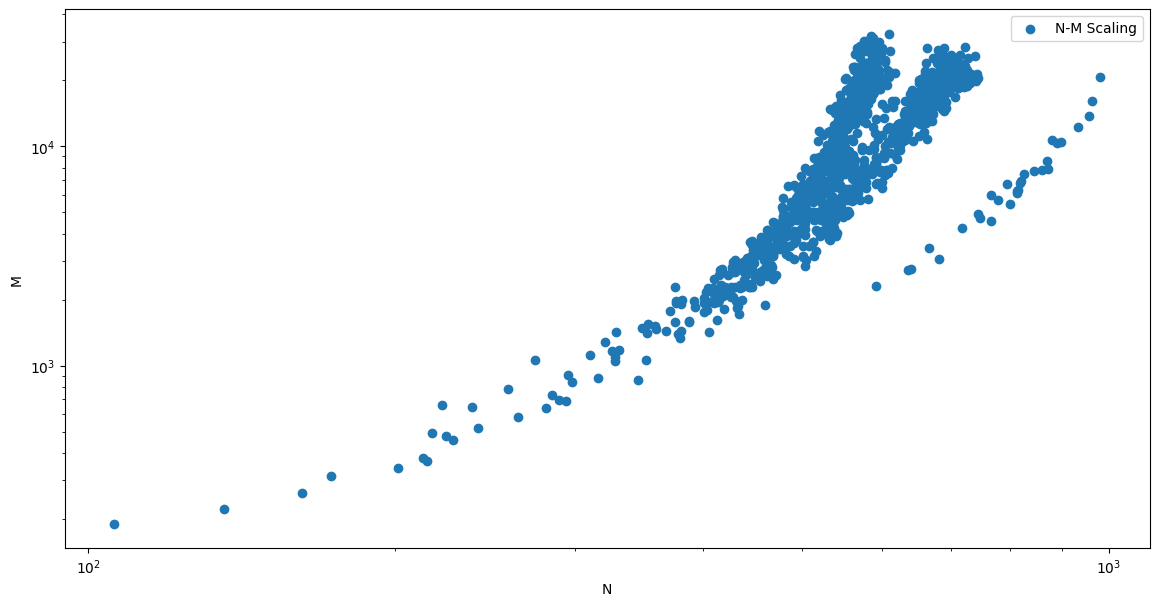

In [6]:
# node_listとedge_listをグラフにプロット
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111)
ax.scatter(wholetime_nmt[0], wholetime_nmt[1], label='N-M Scaling')
ax.set_xlabel('N')
ax.set_ylabel('M')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
plt.show()


In [7]:
# model1を使って、kappaを推定する
def model1(x, kappa):
    a = (1+np.sqrt(1+(32*x/kappa)))/2
    return a*(1-2/a*kappa*(1-(1-kappa/2)**a))

In [18]:
popt, pcov = curve_fit(model1,wholetime_nmt[1],wholetime_nmt[0],p0=0.1)
kappa = popt[0]
print("kappa:", kappa)

kappa: 0.3066825200472426


In [19]:
Np = []
for i in range(len(wholetime_nmt[1])):
    Np.append(1+np.sqrt(1+32*wholetime_nmt[1][i]/kappa)/2)

In [55]:
# model2を使って、Nppを推定する
def model2(x, Npp):
    a = (8*x)/(Npp**2-Npp)
    if a.any() < 0:
        return 0
    res = Npp*(1-(2/a*Npp)*(1-(1-(a/2))**Npp))
    # if res is under 0, return 0
    if res.any() < 0:
        return 0
    else:
        return res

In [56]:
popt2, pcov2 = curve_fit(model2,wholetime_nmt[1],wholetime_nmt[0])
Npp = popt2[0]
print("Np:", Npp)

Np: 1.0


/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_31535/821191384.py:3: RuntimeWarning: divide by zero encountered in divide
  a = (8*x)/(Npp**2-Npp)
/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_31535/821191384.py:3: RuntimeWarning: invalid value encountered in divide
  a = (8*x)/(Npp**2-Npp)
/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_31535/821191384.py:6: RuntimeWarning: invalid value encountered in multiply
  res = Npp*(1-(2/a*Npp)*(1-(1-(a/2))**Npp))
/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_31535/821191384.py:6: RuntimeWarning: divide by zero encountered in divide
  res = Npp*(1-(2/a*Npp)*(1-(1-(a/2))**Npp))
/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_31535/821191384.py:6: RuntimeWarning: invalid value encountered in power
  res = Npp*(1-(2/a*Npp)*(1-(1-(a/2))**Npp))
/Users/yiadka/dev/mobility_code/venv/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters 

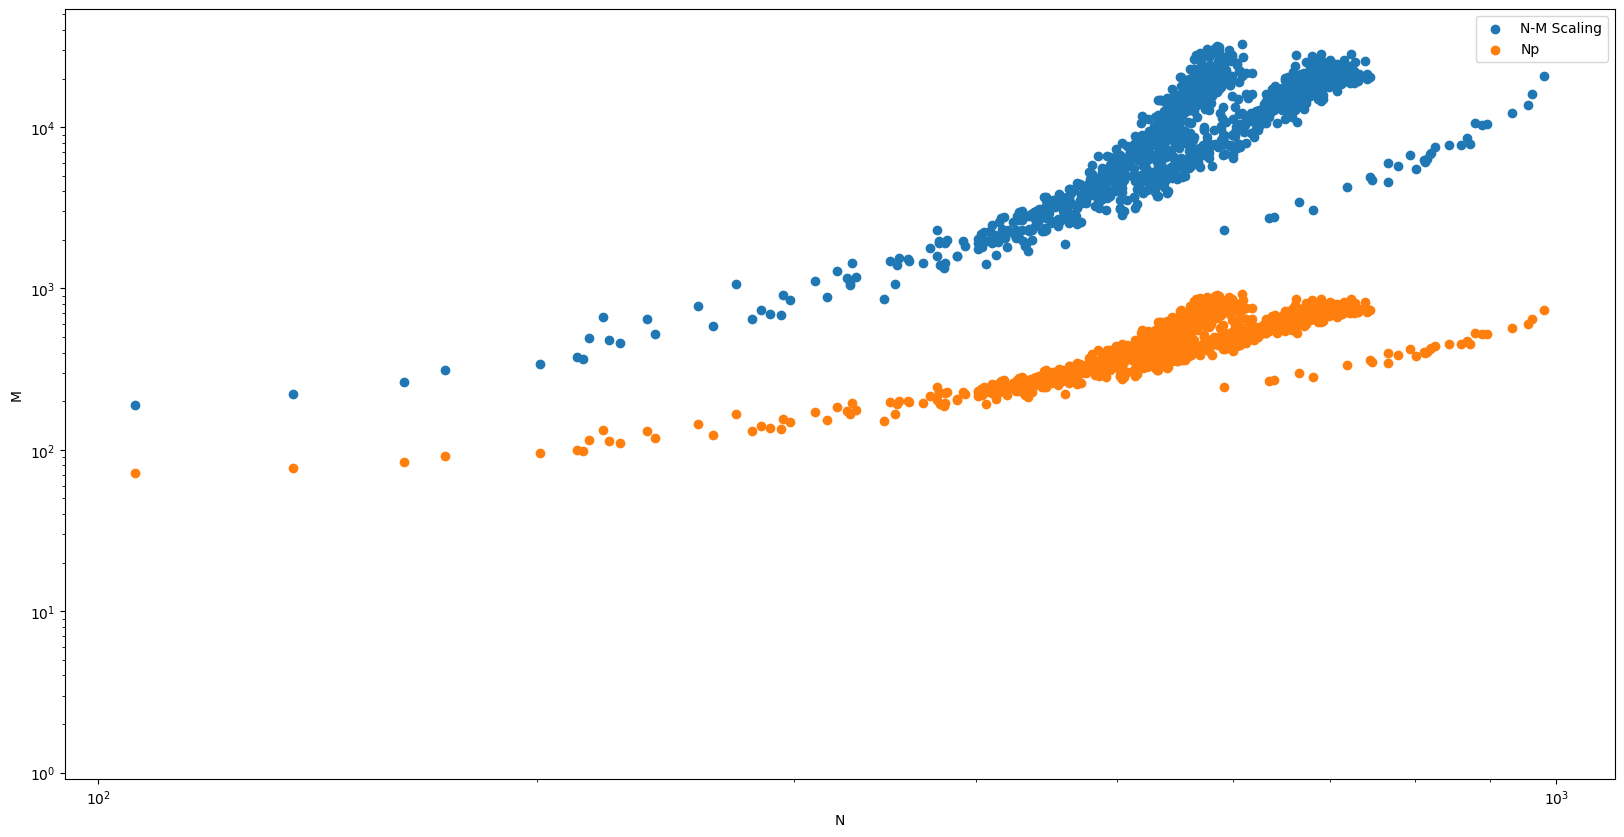

In [20]:
# node_listとedge_listをグラフにプロット
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
ax.scatter(wholetime_nmt[0], wholetime_nmt[1], label='N-M Scaling')
ax.scatter(wholetime_nmt[0], Np, label='Np')
ax.set_xlabel('N')
ax.set_ylabel('M')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
plt.show()
